In [1]:
import numpy as np
import glob, os
from keras import layers as ly
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.layers import Input, Lambda
from keras import losses
from keras.models import model_from_json
import keras.backend.tensorflow_backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
import string

Using TensorFlow backend.


In [2]:
#dir = './sequence/*'
dir = './latest_sequence/bfs-character/*'

In [3]:
# file read
all_names = []
all_data = []
sequence_length = []
alpha = list(string.ascii_uppercase)
data_length = len(glob.glob(dir))
file_predix = './latest_sequence/bfs-character/graph'
for index in range(data_length):
    filename = file_predix + str(index) + "-*"
    files = glob.glob(filename)
    for file in files:
        datasets = []
        all_names.append(file.split('/')[-1].replace('.txt', ''))
        for rf in open(file, 'r'):
            (u, v, w) = rf[1:-2].split(', ')
            datasets.append([alpha.index(u[1])+1, alpha.index(v[1]) +1, float(w)])
        sequence_length.append(len(datasets))
        all_data.append(datasets)
all_data = np.array([np.array(arr) for arr in all_data])

In [4]:
x_train, x_test, train_name, test_name = train_test_split(all_data, all_names, test_size=0.3)
x_test, x_val, test_name, val_name = train_test_split(x_test, test_name, test_size=0.33)

In [5]:
train_name
tr_names= []
for name in train_name:
    tr_names.append(name.split('-')[0].replace('graph', ''))

In [6]:
max_sequence_length = max(sequence_length)
n_features = 3
batch_size = 32
epochs = 200
steps_per_epoch = len(x_train)

In [7]:
def custom_loss(y_true, y_pred):
    loss1 = losses.mean_squared_error(y_true, y_pred)
    loss2 = losses.kld(y_true, y_pred) # categorical_crossentropy
    return loss1 * 0.7 + loss2 * 0.3

In [12]:
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)
    

inputs = Input(shape=(None, 3))
encoded = LSTM(128, return_sequences=True)(inputs)  #activation 안적으면 tanh
encoded = LSTM(64)(encoded)

decoded = Lambda(repeat_vector, output_shape=(None, 64)) ([encoded, inputs]) # inputs의 shape[1] 만큼 encoded 를 반복 생성

decoded = LSTM(64, return_sequences=True)(decoded)
decoded = LSTM(128, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(3))(decoded)
encoder = Model(inputs, encoded)

lstm_autoencoder = Model(inputs, decoded)
lstm_autoencoder.compile(loss=custom_loss, optimizer=Adam())#decay=0.9
#lstm_autoencoder_500 = lstm_autoencoder

In [13]:
def val_generator(x_val):
    idx = 0
    while True:
        yield np.array([x_val[idx]]), np.array([x_val[idx]])
        idx += 1
        if idx >= len(x_val):
            idx = 0

def train_generator(x_train):
    idx = 0
    while True:
        yield np.array([x_train[idx]]), np.array([x_train[idx]])
        idx += 1
        if idx >= len(x_train):
            idx = 0

In [14]:
hist = lstm_autoencoder.fit_generator(train_generator(x_train), epochs=300, steps_per_epoch=steps_per_epoch, verbose=1, validation_steps=len(x_val), validation_data=val_generator(x_val))

Epoch 1/300
6468/6468 [==============================] - 65s 10ms/step - loss: 24.6951 - val_loss: 15.2743
Epoch 2/300
6468/6468 [==============================] - 63s 10ms/step - loss: 13.5587 - val_loss: 12.2123
Epoch 3/300
6468/6468 [==============================] - 64s 10ms/step - loss: 11.1077 - val_loss: 11.6055
Epoch 4/300
6468/6468 [==============================] - 63s 10ms/step - loss: 9.2143 - val_loss: 8.6535
Epoch 5/300
6468/6468 [==============================] - 63s 10ms/step - loss: 7.8064 - val_loss: 7.8116
Epoch 6/300
6468/6468 [==============================] - 63s 10ms/step - loss: 6.9883 - val_loss: 7.4312
Epoch 7/300
6468/6468 [==============================] - 63s 10ms/step - loss: 6.5110 - val_loss: 6.7250
Epoch 8/300
6468/6468 [==============================] - 64s 10ms/step - loss: 6.1313 - val_loss: 6.8325
Epoch 9/300
6468/6468 [==============================] - 63s 10ms/step - loss: 5.5233 - val_loss: 6.5667
Epoch 10/300
6468/6468 [=========================

6468/6468 [==============================] - 62s 10ms/step - loss: 0.5722 - val_loss: 1.2065
Epoch 79/300
6468/6468 [==============================] - 62s 10ms/step - loss: 0.9154 - val_loss: 1.2306
Epoch 80/300
6468/6468 [==============================] - 61s 10ms/step - loss: 0.5492 - val_loss: 1.1453
Epoch 81/300
6468/6468 [==============================] - 61s 9ms/step - loss: 0.5728 - val_loss: 1.1198
Epoch 82/300
6468/6468 [==============================] - 62s 10ms/step - loss: 0.5475 - val_loss: 1.2627
Epoch 83/300
6468/6468 [==============================] - 61s 9ms/step - loss: 0.5296 - val_loss: 1.1838
Epoch 84/300
6468/6468 [==============================] - 62s 10ms/step - loss: 0.5615 - val_loss: 1.2171
Epoch 85/300
6468/6468 [==============================] - 61s 9ms/step - loss: 0.5273 - val_loss: 1.1719
Epoch 86/300
6468/6468 [==============================] - 61s 9ms/step - loss: 0.5989 - val_loss: 1.0575
Epoch 87/300
6468/6468 [==============================] - 61s 9

6468/6468 [==============================] - 65s 10ms/step - loss: 0.3244 - val_loss: 0.9563
Epoch 156/300
6468/6468 [==============================] - 63s 10ms/step - loss: 0.3611 - val_loss: 0.9041
Epoch 157/300
6468/6468 [==============================] - 63s 10ms/step - loss: 0.3238 - val_loss: 0.8685
Epoch 158/300
6468/6468 [==============================] - 62s 10ms/step - loss: 0.3051 - val_loss: 0.8972
Epoch 159/300
6468/6468 [==============================] - 62s 10ms/step - loss: 0.3209 - val_loss: 1.0019
Epoch 160/300
6468/6468 [==============================] - 62s 10ms/step - loss: 0.3150 - val_loss: 0.9489
Epoch 161/300
6468/6468 [==============================] - 62s 10ms/step - loss: 0.3295 - val_loss: 0.9288
Epoch 162/300
6468/6468 [==============================] - 62s 10ms/step - loss: 0.3730 - val_loss: 0.9146
Epoch 163/300
6468/6468 [==============================] - 62s 10ms/step - loss: 0.2917 - val_loss: 0.9541
Epoch 164/300
6468/6468 [==========================

6468/6468 [==============================] - 64s 10ms/step - loss: 0.2556 - val_loss: 0.8544
Epoch 232/300
6468/6468 [==============================] - 64s 10ms/step - loss: 0.2558 - val_loss: 0.8203
Epoch 233/300
6468/6468 [==============================] - 64s 10ms/step - loss: 0.2459 - val_loss: 0.8209
Epoch 234/300
6468/6468 [==============================] - 64s 10ms/step - loss: 0.2548 - val_loss: 0.8420
Epoch 235/300
6468/6468 [==============================] - 63s 10ms/step - loss: 0.2437 - val_loss: 0.8224
Epoch 236/300
6468/6468 [==============================] - 63s 10ms/step - loss: 0.2628 - val_loss: 0.8012
Epoch 237/300
6468/6468 [==============================] - 63s 10ms/step - loss: 0.2514 - val_loss: 0.8350
Epoch 238/300
6468/6468 [==============================] - 63s 10ms/step - loss: 0.2341 - val_loss: 0.9046
Epoch 239/300
6468/6468 [==============================] - 63s 10ms/step - loss: 0.2399 - val_loss: 0.8204
Epoch 240/300
6468/6468 [==========================

In [15]:
# MODEL SAVE
model_json = lstm_autoencoder.to_json()
filename = 'latest_mse_kld_lstmae1' #input('filename: ') 
with open('model_save/mse_kld_models/' + filename + '.json', 'w') as file:
    file.write(model_json)
lstm_autoencoder.save_weights('model_save/mse_kld_models/weights_' +  filename + '.h5')

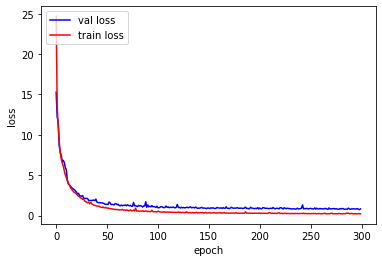

In [23]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['val_loss'], 'b', label='val loss')
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.show()

In [7]:
filename = "latest_mse_kld_lstmae"
# MODEL LOAD
loaded_model = model_from_json(open('model_save/mse_kld_models/' +filename + '.json').read())
loaded_model.load_weights('model_save/mse_kld_models/weights_' + filename + '.h5')

W1010 15:50:46.376312 140028240148224 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1010 15:50:46.386179 140028240148224 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1010 15:50:46.388441 140028240148224 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1010 15:50:46.865248 140028240148224 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



In [16]:
loaded_model = lstm_autoencoder

In [17]:
mean= 0
for xt in x_test:
    xt = xt.reshape(1, xt.shape[0], xt.shape[1])
    out = loaded_model.predict(xt)
    mean += ((xt-out)**2).mean(axis=None)
print(mean/len(x_test))

1.0167612844547782


In [ ]:
encoder = Model(loaded_model.input, loaded_model.layers[3].output)

In [ ]:
test = x_test[0].reshape(1, x_test[0].shape[0], x_test[0].shape[1])
latent_vector = []
for x in x_test:
    x = x.reshape(1, x.shape[0], x.shape[1])
    latent_vector.append(encoder.predict(x)[0])

In [23]:
model_path = 'model_save/mse_kld_models/weights' + '{epoch:02d}-{loss:.4f}.h5'
early_stopping_callback = EarlyStopping(monitor='loss', patience=200)
checkpoint_callback = ModelCheckpoint(model_path, monitor='loss', verbose = 1, save_best_only = True, save_weights_only = True, mode='min', period=100)